In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Importation des données

In [37]:
datas = {
    f"data{i}": np.loadtxt(f"./data/data_tp{i}_app.txt") for i in range(1, 4)
}

for data in datas:
    datas[data] = pd.DataFrame(datas[data], columns=["y", "x1", "x2"])


valid_data = {
    f"data{i}": np.loadtxt(f"./data/data_tp{i}_dec.txt") for i in range(1, 4)
}


for data in valid_data:
    valid_data[data] = pd.DataFrame(valid_data[data], columns=["y", "x1", "x2"])

In [38]:
# image gif
description = {
    f"desc_tp{i}": plt.imread(f"./data/data_tp{i}_app.gif") for i in range(1, 4)
}


# Fonctions ou classes utiles

In [39]:
from abc import ABC, abstractmethod

class Modele(ABC):
    def __init__(self):
        pass
    
    @abstractmethod
    def fit(self, X, y):
        pass

       
    def plot_decision(self, X, sample = 300):
        """Uses Matplotlib to plot and fill a region with 2 colors
        corresponding to 2 classes, separated by a decision boundary

        Parameters
        ----------
        sample : int, optional
            Number of samples on each feature (default is 300)
        """

        x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
        x2_min, x2_max = X[:, 1].min(), X[:, 1].max()
        x1_list = np.linspace(x1_min, x1_max, sample)
        x2_list = np.linspace(x2_min, x2_max, sample)
        y_grid_pred = [[self.predictor(np.array([x1,x2])) for x1 in x1_list] for x2 in x2_list] 
        plt.contourf(x1_list, x2_list, y_grid_pred, levels=1,alpha=0.35)


    def plot_decision_multi(self, X, sample = 300):
        """Uses Matplotlib to plot and fill a region with 2 colors
        corresponding to 2 classes.

        Parameters
        ----------
        sample : int, optional
            Number of samples on each feature (default is 300)
        """

        x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
        x2_min, x2_max = X[:, 1].min(), X[:, 1].max()
        x1_list = np.linspace(x1_min, x1_max, sample)
        x2_list = np.linspace(x2_min, x2_max, sample)
        y_grid_pred = [[self.predictor (np.array([[x1,x2]]))[0] for x1 in x1_list] for x2 in x2_list] 
        l = np.shape(np.unique(y_grid_pred))[0] - 1
        plt.contourf(x1_list, x2_list, y_grid_pred, levels=l, colors=plt.rcParams['axes.prop_cycle'].by_key()['color'], alpha=0.35)


In [163]:
def top_k_accuracy(X, y_true, modele : Modele, k=2):
    labels = modele.rank_predictor(X)
    score = [ 1 if y_true[i] in labels[i,:k] else 0 for i in range(len(y_true))]
    return np.mean(score)


def validate(valid_data, modele : Modele, name=None):
    
    x_valid, y_valid = valid_data[["x1", "x2"]].to_numpy(), valid_data.y.to_numpy()
    classes = np.unique(y_valid)
    
    y_pred = modele.predictor(x_valid)
    valid_data["y_pred"] = y_pred
    top1 = top_k_accuracy(x_valid, y_valid, modele, 1)
    top2 = top_k_accuracy(x_valid, y_valid, modele, 2)
    print(f"top1 : {top1}\n top2 : {top2}")

    matrice_confusion = np.zeros((len(classes), len(classes)))
    matrice_confusion = pd.DataFrame(matrice_confusion)
    matrice_confusion.columns =  np.arange(len(classes))
    matrice_confusion.index = matrice_confusion.columns
    
    for classe1 in  range(len(classes)):
        for classe2 in  range(len(classes)):
            matrice_confusion.loc[classe1, classe2] = valid_data[(valid_data.y_pred == classe1+1) & (valid_data.y == classe2+1)].shape[0]


    if len(classes) == 2:
        plt.figure()

        plt.axis('off')
        plt.show()

        plt.figure()
        
        plt.text(0, 0, f"vrai positive : {matrice_confusion.loc[0, 0]}", ha='center', fontsize=12, va='center', color='red')
        plt.text(1, 0, f"faux positive : {matrice_confusion.loc[0, 1]}", ha='center', fontsize=12,  va='center', color='red')
        plt.text(0, 1, f"faux negative : {matrice_confusion.loc[1, 0]}", ha='center', fontsize=12, va='center', color='red')
        plt.text(1, 1, f"vrai negative : {matrice_confusion.loc[1, 1]}", ha='center', fontsize=12, va='center', color='red')

        plt.axis("off")
        plt.imshow(matrice_confusion, cmap='YlGnBu', interpolation='nearest')
        plt.show()
    else:
        plt.figure(figsize=(8, 6))
        sns.heatmap(matrice_confusion, annot=True, cmap='coolwarm', fmt='.1f', linewidths=.5)
        plt.title('Matrice de confusion '+name )
        plt.xlabel('Columns')
        plt.ylabel('Rows')
        plt.show()

def show(df, save=True, title=None, delta =None):
    
    classes = df.y.unique()
    marker =  ["+","x",".","o",",","*","v","^","<",">","1","2","3","4","8","s","p","P","*","h","H","X","D","d","|","_",0,1,2,3,4,5,6,7,8,9,10,11]
    repartitons = {classe : df[df.y == classe] for classe in classes}
    
    plt.figure(figsize=(10, 8))
    
    for i, classe in enumerate(classes):
        card = repartitons[classe].size
        plt.scatter(repartitons[classe].x1, repartitons[classe].x2, marker=marker[i], alpha=.7, label=f"{str(classe)}, {card}")


    if title is not None:
        plt.title(title)

    if delta is not None:
        for deltai in delta:
            plt.axvline(deltai )
            plt.text(deltai, 2, f"{np.round(deltai)}")

    plt.axis("equal")
    plt.legend()

def plot_decision(x1_min, x1_max, x2_min, x2_max, prediction, sample = 300):
    """Uses Matplotlib to plot and fill a region with 2 colors
    corresponding to 2 classes, separated by a decision boundary

    Parameters
    ----------
    x1_min : float
        Minimum value for the first feature
    x1_max : float
        Maximum value for the first feature
    x2_min : float
        Minimum value for the second feature
    x2_max : float
        Maximum value for the second feature
    prediction :  (x : 2D vector) -> label : int
        Prediction function for decision
    sample : int, optional
        Number of samples on each feature (default is 300)
    """
    x1_list = np.linspace(x1_min, x1_max, sample)
    x2_list = np.linspace(x2_min, x2_max, sample)
    y_grid_pred = [[prediction(np.array([x1,x2])) for x1 in x1_list] for x2 in x2_list] 
    plt.contourf(x1_list, x2_list, y_grid_pred, levels=1,alpha=0.35)


def plot_decision_multi(x1_min, x1_max, x2_min, x2_max, prediction, sample = 300):
    """Uses Matplotlib to plot and fill a region with 2 colors
    corresponding to 2 classes.

    Parameters
    ----------
    x1_min : float
        Minimum value for the first feature
    x1_max : float
        Maximum value for the first feature
    x2_min : float
        Minimum value for the second feature
    x2_max : float
        Maximum value for the second feature
    prediction :  (x : 2D vector) -> label : int
        Prediction function for a vector x
    sample : int, optional
        Number of samples on each feature (default is 300)
    """
    x1_list = np.linspace(x1_min, x1_max, sample)
    x2_list = np.linspace(x2_min, x2_max, sample)
    y_grid_pred = [[prediction(np.array([[x1,x2]]))[0] for x1 in x1_list] for x2 in x2_list] 
    l = np.shape(np.unique(y_grid_pred))[0] - 1
    plt.contourf(x1_list, x2_list, y_grid_pred, levels=l, colors=plt.rcParams['axes.prop_cycle'].by_key()['color'], alpha=0.35)

def execute_modele(modele : Modele, sample=300):
    for data in datas:
        X_train = datas[data][["x1", "x2"]].to_numpy()
        y_train = datas[data].y.to_numpy()
        X_valid = valid_data[data][["x1", "x2"]].to_numpy()
        y_valid = valid_data[data].y.to_numpy()
        modele.fit(X_train, y_train)
        show(valid_data[data], title=f"Train Data {data[-1]}")
        modele.plot_decision_multi(X_valid, sample=sample)
        validate(valid_data[data], modele, name=f"Validation Data {data[-1]}")
        plt.show()


# TP1 : Approche Bayessienne de la decision

class 1.0 mean: [-6.10093065  5.99640958] count: 100
class 2.0 mean: [5.79953605 6.17117138] count: 100
class 3.0 mean: [ 5.7769986  -5.92582723] count: 100
class 4.0 mean: [-5.92499809 -6.01392348] count: 100
class 5.0 mean: [-0.01358148  0.25138977] count: 100


<Figure size 640x480 with 0 Axes>

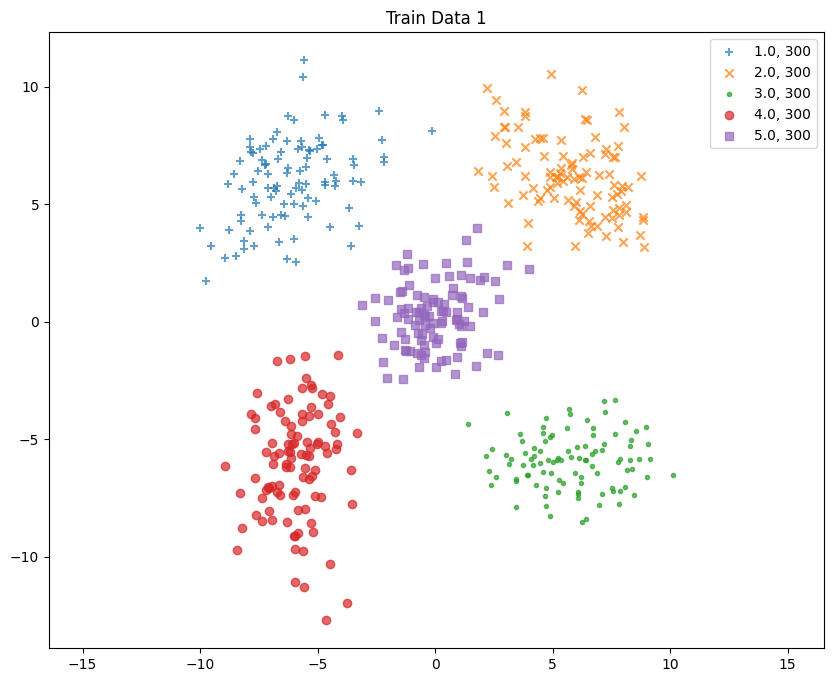

In [41]:
plt.figure()

X1 = datas["data1"][["x1", "x2"]].to_numpy()
y1 = datas["data1"].y.to_numpy()

classes = np.unique(y1)

show(datas["data1"], title="Train Data 1")
for classe in classes:
   print(f"class {classe} mean: {X1[y1 == classe].mean(axis=0)} count: {X1[y1 == classe].shape[0]}")

## Estimation Gaussien

### Distance Euclidienne

In [61]:
class EuclideanClassifier(Modele):
    def __init__(self):
        pass
    
    def fit(self, X, y, k=5):
        classes = np.unique(y)
        means = np.array([X[y == classe].mean(axis=0) for classe in classes])
        
        self.predictor = self._get_predictor(means)
        self.rank_predictor = self._get_rank_predictor(means, k)

    def _get_predictor(self, means):
        def predict(x):
            if len(x.shape) == 1:
                return np.argmin([np.linalg.norm(mean - x) for mean in means]) + 1
            return np.argmin([np.linalg.norm(mean - x, axis=1) for mean in means], axis=0)  + 1
        return predict
    
    def _get_rank_predictor(self, means, k):
        def predict(x):
            if len(x.shape) == 1:
                return (np.argsort([np.linalg.norm(mean - x) for mean in means])[:k]) + 1
            return (np.argsort([np.linalg.norm(mean - x, axis=1) for mean in means], axis=0)[:k]).T + 1
        return predict


euclide_classifer = EuclideanClassifier()

top1 : 0.002
 top2 : 0.208


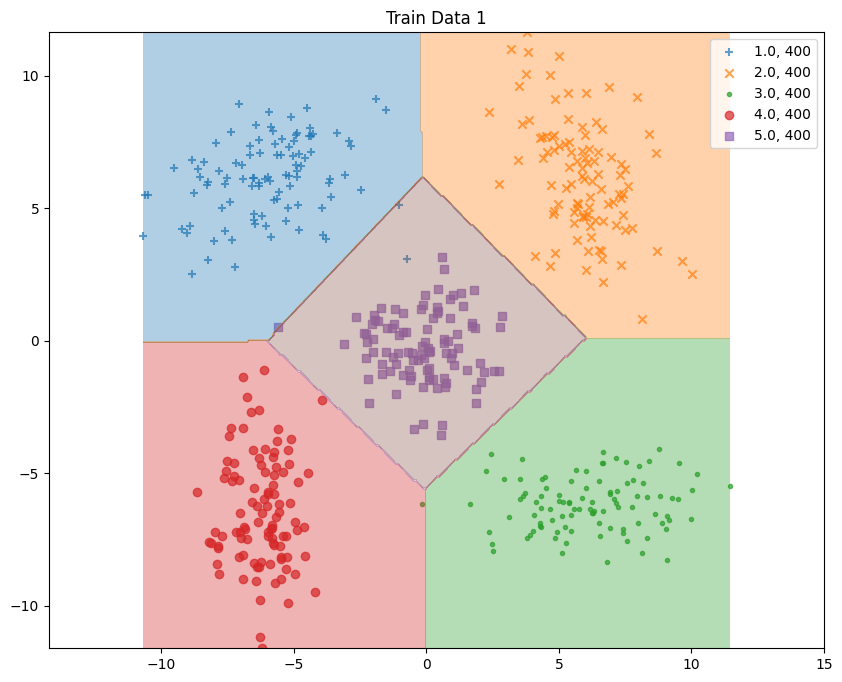

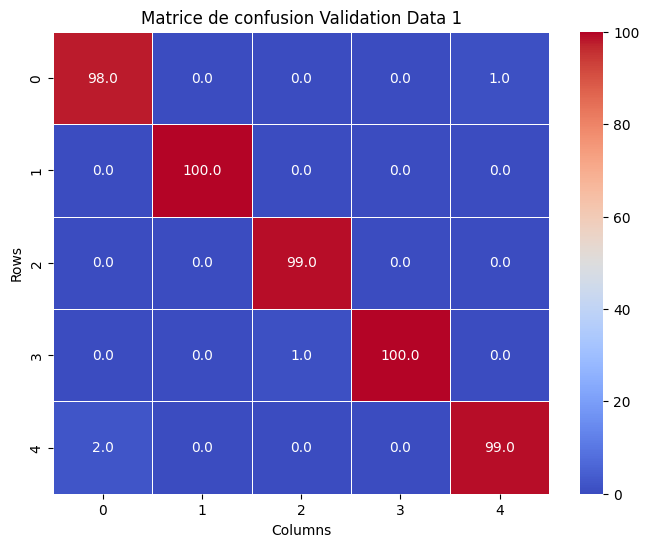

top1 : 0.004
 top2 : 0.212


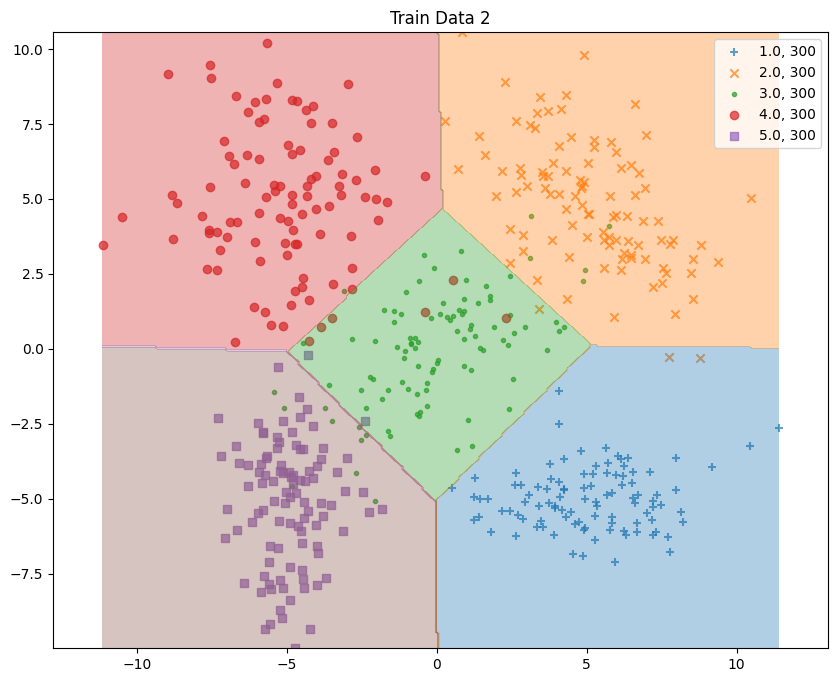

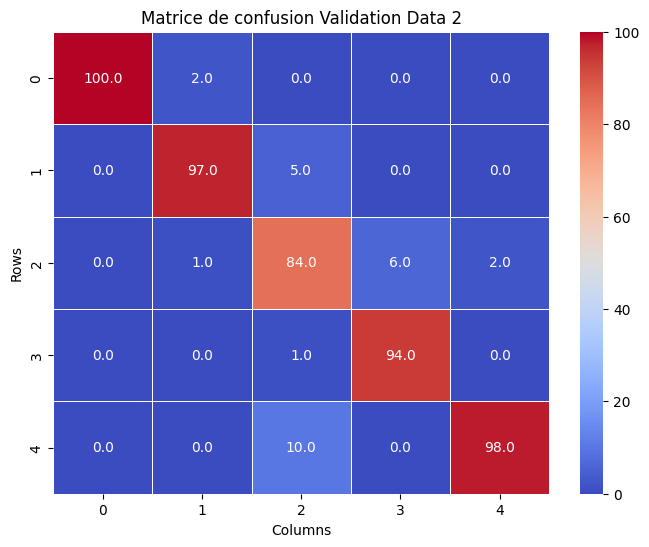

top1 : 0.05
 top2 : 0.158


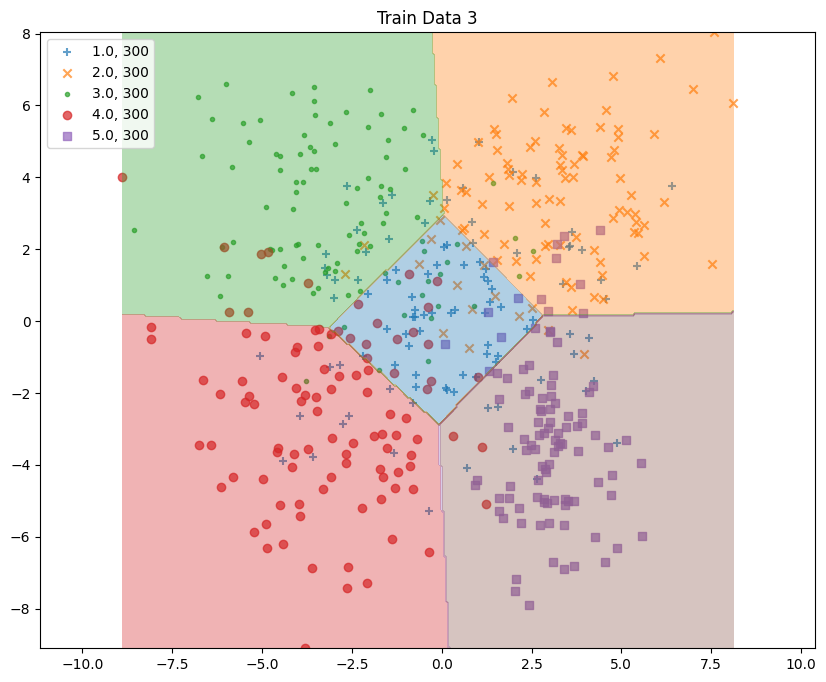

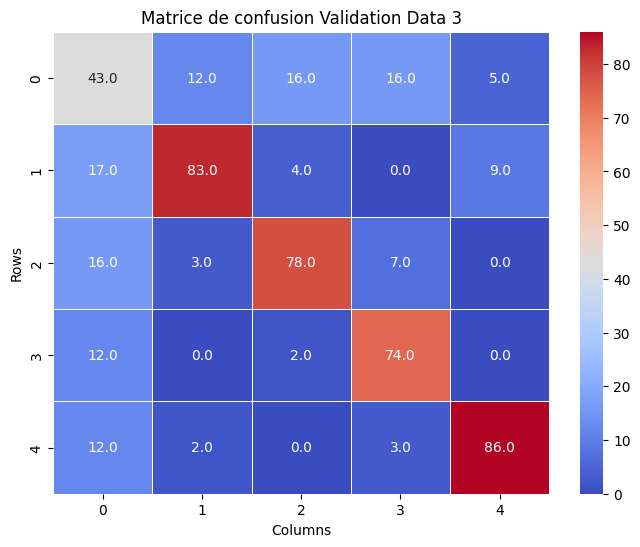

In [55]:
execute_modele(euclide_classifer)

## Distance de mahalanobis

In [105]:

class MahalanobisClassifier(Modele):
    def __init__(self):
        self.predictor = None
    
    def fit(self, X, y):
        classes = np.unique(y)
        means = np.array([X[y == classe].mean(axis=0) for classe in classes])
        covs = np.array([np.cov(X[y == classe].T, rowvar=True) for classe in classes])
        inv_covs = np.array([np.linalg.inv(cov) for cov in covs])
        probas = np.array([X[y == classe].shape[0]/X.shape[0] for classe in classes])
        
        self.predictor = self._get_predictor(means, covs)
        self.rank_predictor = self._get_rank_predictor(means, covs)

    def _get_predictor(self, means, covs, distance=lambda x, y, sigma: np.sum((x@np.linalg.inv(sigma))*y, axis=1)):
        def predict(x):
            if len(x.shape) == 1:
                x = np.expand_dims(x, axis=0)
                return np.argmin([distance(x-mean, x-mean, cov) for mean, cov in zip(means, covs)]) + 1
            return np.argmin([distance(x-mean, x-mean, cov) for mean, cov in zip(means, covs)], axis=0) + 1
        return predict

    def _get_rank_predictor(self, means, covs, k=5,distance=lambda x, y, sigma: np.sum((x@np.linalg.inv(sigma))*y, axis=1)):
        def predict(x):
            if len(x.shape) == 1:
                x = np.expand_dims(x, axis=0)
                pred =(np.argsort([distance(x-mean, x-mean, cov) for mean, cov in zip(means, covs)], axis=0)) + 1
                return pred.reshape(-1)[:k]
            return (np.argsort([distance(x-mean, x-mean, cov) for mean, cov in zip(means, covs)], axis=0)[:k]).T + 1
        return predict 

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

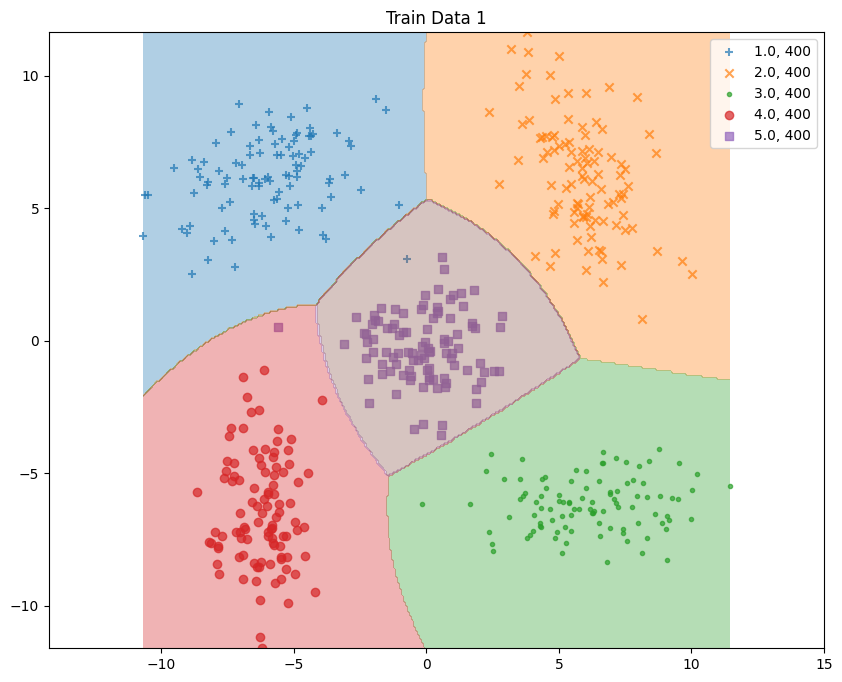

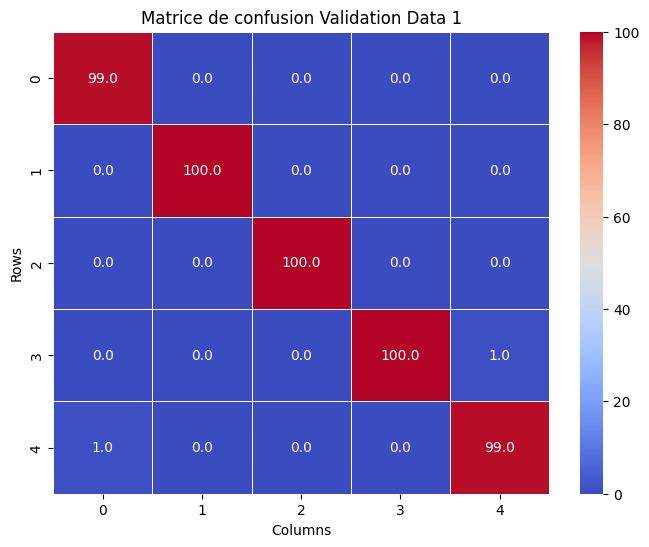

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

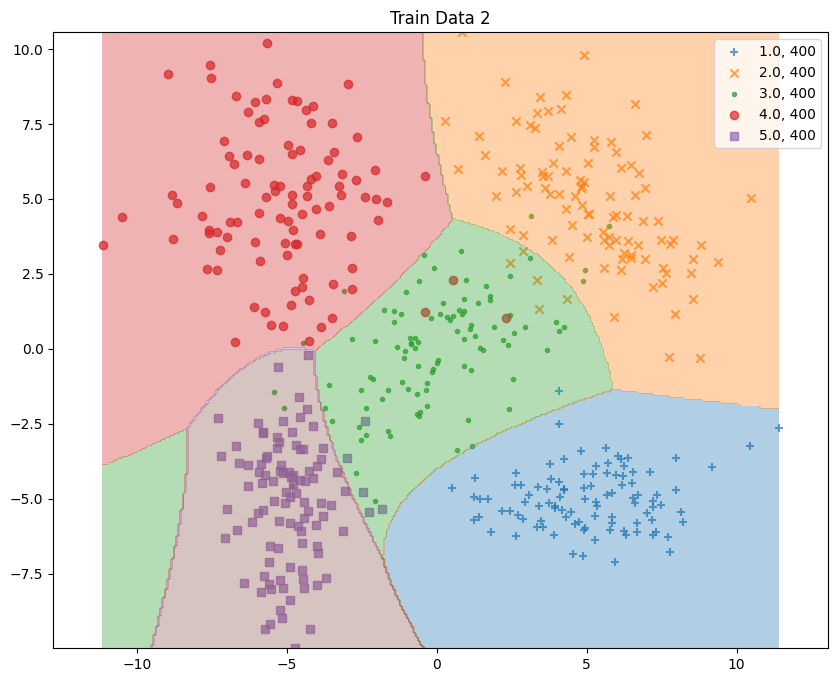

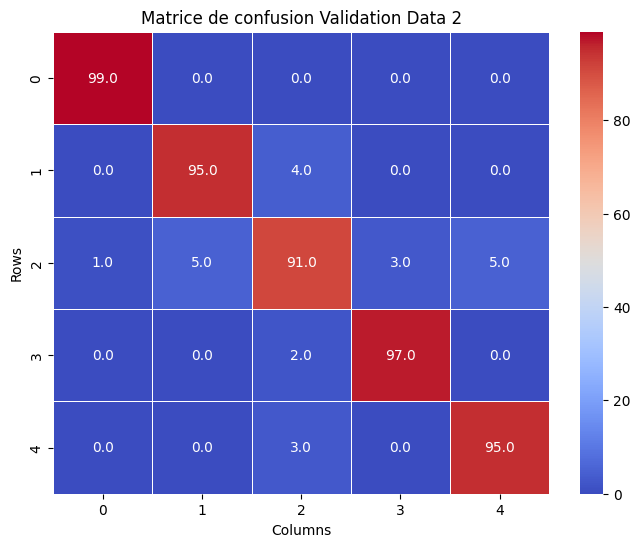

[1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 

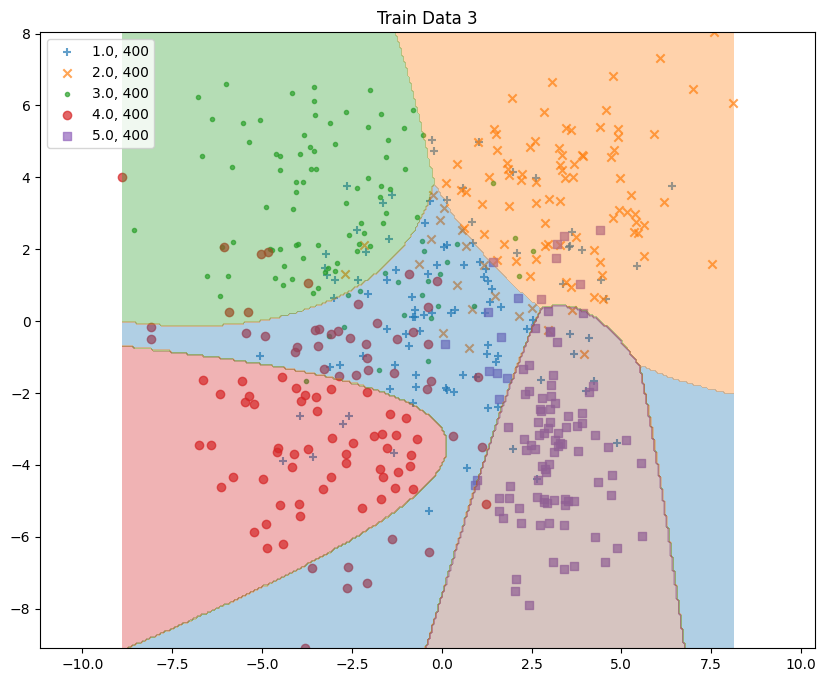

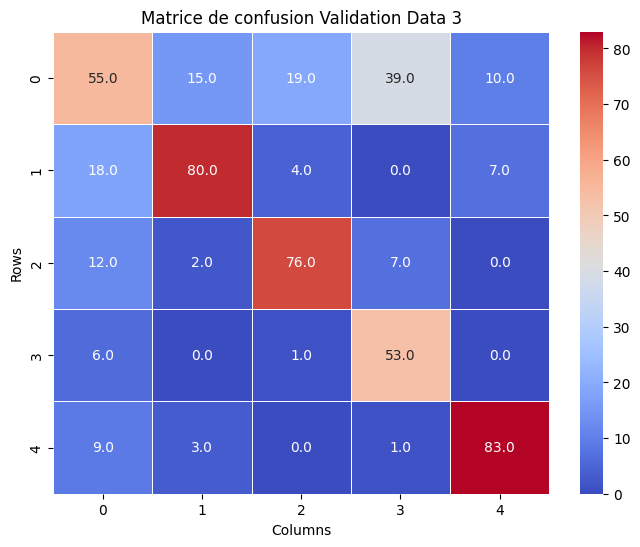

In [107]:
mahalanobis_classifier = MahalanobisClassifier()
execute_modele(mahalanobis_classifier)

## Parzen

In [155]:
def gaussian_kernel(x, d=0.2):
    return np.exp(-np.linalg.norm(x)**2 / (2 * d**2))

class Parzen(Modele):
    def __init__(self, kernel=gaussian_kernel):
        self.kernel = kernel
        self.predictor = None
        self.rank_predictor = None

    def fit(self, X, y, h=1):
        classes = np.unique(y)
        self.estimators = []
        self.X = X
        self.y = y
        self.predictor = self._get_predictor()
        self.rank_predictor = self._get_rank_predictor()

    
    def _get_predictor(self):
        def predict(x):
            estimations = []
            for classe in classes:
                for xi in self.X[y1 == classe]:
                    diff = np.expand_dims(x - xi[0], axis=0)  # Ajouter une dimension pour le tenseur

                    for i in range(1, len(xi)):
                        diff = np.concatenate((diff, np.expand_dims(x - xi[i], axis=0)), axis=0)

                    # Appliquer la fonction de noyau à chaque élément de diff
                    kernel_diff = np.vectorize(self.kernel, signature='(n)->()')(diff)

                    estimation = np.sum(kernel_diff, axis=0)
                estimations.append(estimation)

            estimations = np.array(estimations)
            pred = np.argmax(estimations, axis=0) + 1
            return pred
        return predict

    def _get_rank_predictor(self, k=5):
        def predict(x):
            estimations = []
            for classe in classes:
                for xi in self.X[y1 == classe]:
                    diff = np.expand_dims(x - xi[0], axis=0)  # Ajouter une dimension pour le tenseur

                    for i in range(1, len(xi)):
                        diff = np.concatenate((diff, np.expand_dims(x - xi[i], axis=0)), axis=0)

                    # Appliquer la fonction de noyau à chaque élément de diff
                    kernel_diff = np.vectorize(self.kernel, signature='(n)->()')(diff)

                    estimation = np.sum(kernel_diff, axis=0)
                estimations.append(estimation)

            estimations = np.array(estimations)
            pred = (np.argsort(estimations, axis=0)[-k:]).T + 1
            return pred
        return predict

top1 : 0.2
 top2 : 0.216


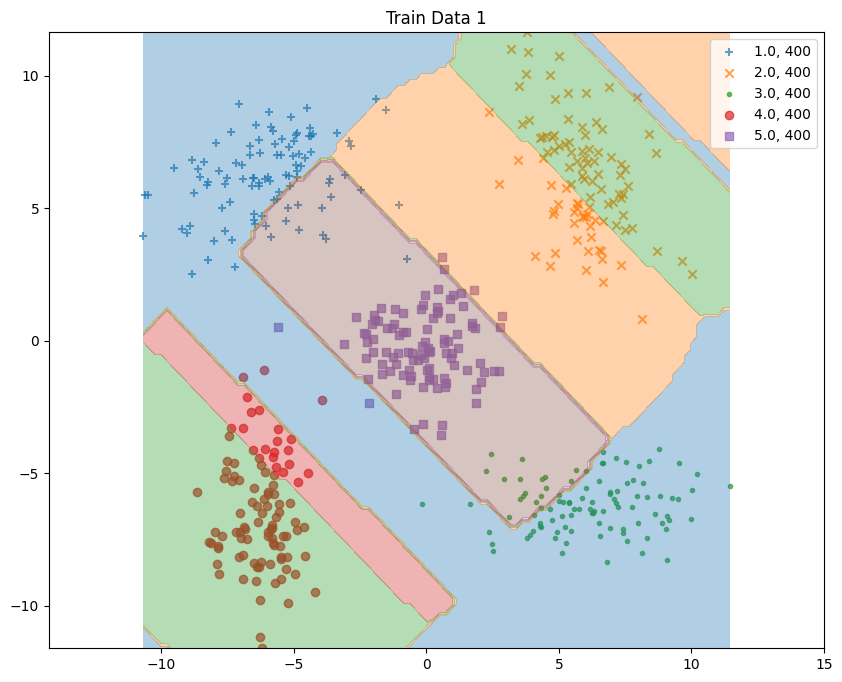

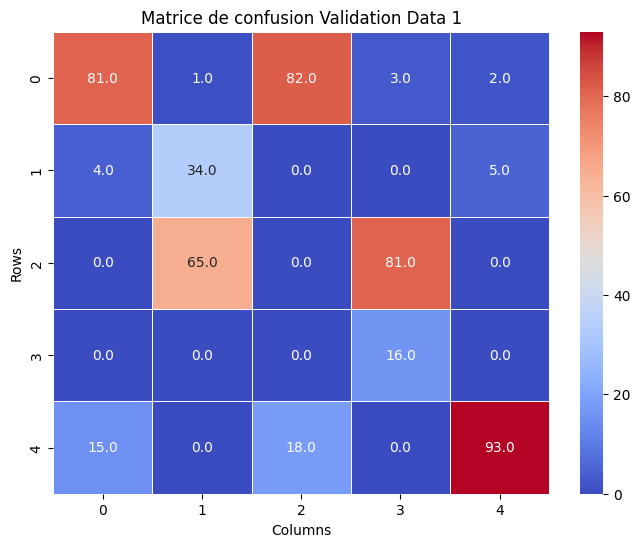

KeyboardInterrupt: 

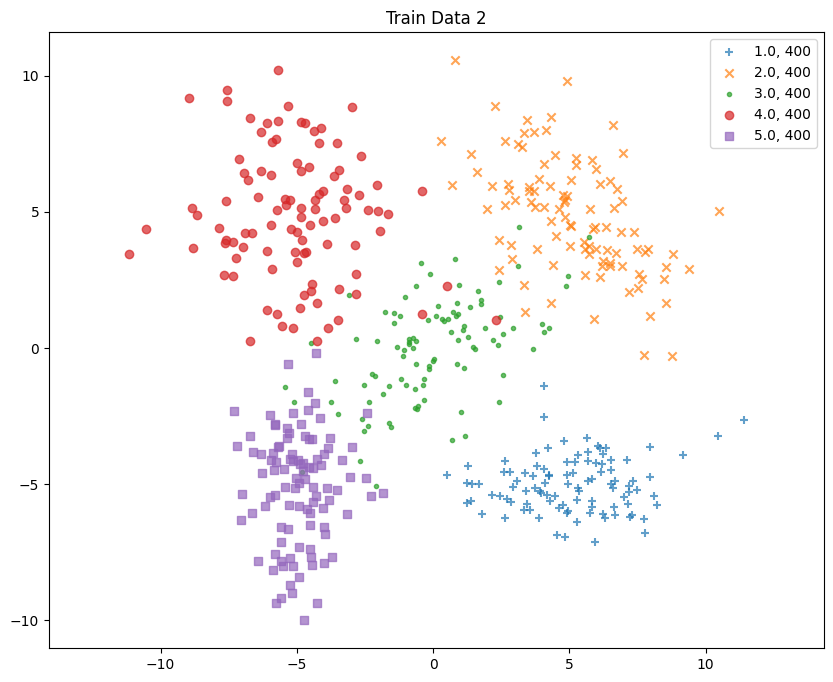

In [164]:
parzen = Parzen()
execute_modele(parzen, sample=100)

## K plus proches voisins

## Séperation Lineaire

In [1]:
#n